

###  Exploratory Data Analysis (EDA) on Student Grades

**Goal:** practice end‑to‑end EDA on a small, intentionally "messy" dataset (35 students).  
You will:
- Generate **synthetic data** (First Name, Last Name, Grade).  
- **Inject data issues**: missing values, negative grades, out-of-range values (e.g., 540).  
- Perform **EDA**: preview, schema, summary stats, missingness, range checks, outlier flags.  
- **Fix errors** with documented, reproducible rules.  
- **Visualize** the distribution **before & after** cleaning.  

> Replace or extend any section with your own dataset later. Keep the *structure* and *explanations*.



## 1) Environment Setup

We use standard libraries only:
- `pandas` for data wrangling
- `numpy` for random generation and numeric ops
- `matplotlib` for basic plots

> No external installs required. If you run into missing modules, install them in your environment (e.g., `pip install pandas numpy matplotlib`).


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
rng = np.random.default_rng(4064)
pd.set_option('display.max_rows', 50)
print("Environment ready.")

Environment ready.



## 2) Generate Synthetic Data (35 students)

**Design:**
- Randomly sample first and last names from small lists.
- Generate grades around a typical distribution (mean≈75, std≈12).
- Create a DataFrame with columns: `FirstName`, `LastName`, `Grade`.

We'll **intentionally introduce errors** in the next step.


In [2]:

# Small name banks (edit/expand as you like)
first_names = [
    "Alex","Taylor","Jordan","Riley","Casey","Avery","Morgan","Quinn","Jamie","Skyler",
    "Sam","Cameron","Drew","Jesse","Parker","Rowan","Hayden","Reese","Emerson","Logan",
    "Milan","Noa","Eden","Remy","Ari","Kendall","Harley","Corey","Shay","Sage",
    "Blake","Shawn","Robin","Kris","Cody"
]

last_names = [
    "Smith","Lee","Patel","Brown","Martin","Garcia","Nguyen","Johnson","Williams","Davis",
    "Miller","Wilson","Anderson","Thomas","Lopez","Harris","Clark","Lewis","Walker","Young",
    "King","Wright","Hill","Scott","Green","Baker","Adams","Nelson","Carter","Mitchell",
    "Perez","Roberts","Turner","Phillips","Campbell"
]

# Generate base grades ~ N(75, 12), clipped to [0, 100] initially (we'll add errors later)
base_grades = np.clip(rng.normal(loc=75, scale=12, size=35), 0, 100).round(1)

df = pd.DataFrame({
    "FirstName": first_names,
    "LastName": last_names,
    "Grade": base_grades
})

df.head(10)

,FirstName,LastName,Grade
0,Alex,Smith,77.8
1,Taylor,Lee,78.5
2,Jordan,Patel,82.5
3,Riley,Brown,64.6
4,Casey,Martin,65.3
5,Avery,Garcia,61.7
6,Morgan,Nguyen,68.4
7,Quinn,Johnson,65.0
8,Jamie,Williams,79.8
9,Skyler,Davis,66.7



## 3) Inject Data Issues (Missing, Negative, Out-of-Range)

We simulate common data quality problems:
- Missing values (`NaN`)
- Negative grades (e.g., `-10`)
- Out-of-range high values (e.g., `540` where `54` was intended)

> **Why simulate problems?** EDA isn't just stats; it's about *diagnosing and repairing* real‑world messiness.


In [3]:

df_dirty = df.copy()

# Inject a few issues deterministically so everyone's notebook is similar
issue_indices = rng.choice(df_dirty.index, size=6, replace=False)

# 2 missing grades
df_dirty.loc[issue_indices[0], "Grade"] = np.nan
df_dirty.loc[issue_indices[1], "Grade"] = np.nan

# 2 negative grades
df_dirty.loc[issue_indices[2], "Grade"] = -10
df_dirty.loc[issue_indices[3], "Grade"] = -3

# 1 extreme high (likely 10x typo)
df_dirty.loc[issue_indices[4], "Grade"] = 540

# 1 slightly >100 (e.g., 104) to test upper-bound fix
df_dirty.loc[issue_indices[5], "Grade"] = 104

print("Indices with injected issues:", issue_indices.tolist())
df_dirty.head(15)

Indices with injected issues: [11, 12, 19, 30, 2, 24]


,FirstName,LastName,Grade
0,Alex,Smith,77.8
1,Taylor,Lee,78.5
2,Jordan,Patel,540.0
3,Riley,Brown,64.6
4,Casey,Martin,65.3
5,Avery,Garcia,61.7
6,Morgan,Nguyen,68.4
7,Quinn,Johnson,65.0
8,Jamie,Williams,79.8
9,Skyler,Davis,66.7



## 4) EDA: Quick Preview & Schema

Look at a **sample**, the **schema**, and **summary statistics** to get a sense of the data.


In [4]:

print("Head:")
display(df_dirty.head())

print("\nInfo:")
display(df_dirty.info())

print("\nDescribe (numeric):")
display(df_dirty.describe())

Head:


,FirstName,LastName,Grade
0,Alex,Smith,77.8
1,Taylor,Lee,78.5
2,Jordan,Patel,540.0
3,Riley,Brown,64.6
4,Casey,Martin,65.3



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FirstName  35 non-null     object 
 1   LastName   35 non-null     object 
 2   Grade      33 non-null     float64
dtypes: float64(1), object(2)
memory usage: 968.0+ bytes


None


Describe (numeric):


,Grade
count,33.000000
mean,83.778788
std,85.049294
min,-10.000000
25%,65.000000
50%,72.500000
75%,81.600000
max,540.000000



## 5) Missingness & Validity Checks

**Checks:**
- Missing values per column
- Count invalid grades: `<0` or `>100`
- Identify obvious 10× typos (e.g., values > 100 and ending with a '0')

> These *rule‑based* checks should be **clear** and **defensible**. Document your assumptions.


In [5]:

missing_counts = df_dirty.isna().sum()

invalid_negative = (df_dirty["Grade"] < 0).sum(skipna=True)
invalid_over_100 = (df_dirty["Grade"] > 100).sum(skipna=True)

# flag potential 10x typos: >100 and approximate multiple of 10 after rounding
potential_ten_x = df_dirty["Grade"].apply(lambda x: isinstance(x, (int, float)) and x>100 and abs(x/10 - round(x/10)) < 1e-9)

summary_checks = pd.DataFrame({
    "missing": missing_counts,
})
print("Missing values per column:")
display(summary_checks)

print(f"Invalid negatives: {invalid_negative}")
print(f"Invalid >100: {invalid_over_100}")
print("Potential 10x-typos (value > 100 and ending in 0):")
display(df_dirty.loc[potential_ten_x.fillna(False), ["FirstName","LastName","Grade"]])

Missing values per column:


,missing
FirstName,0
LastName,0
Grade,2


Invalid negatives: 2
Invalid >100: 2
Potential 10x-typos (value > 100 and ending in 0):


,FirstName,LastName,Grade
2,Jordan,Patel,540.0



## 6) Visualize Distribution (Before Cleaning)

Plot the grade distribution to see the impact of errors and missing values.
> Keep plots simple and readable. (One chart per cell; do not set custom colors.)


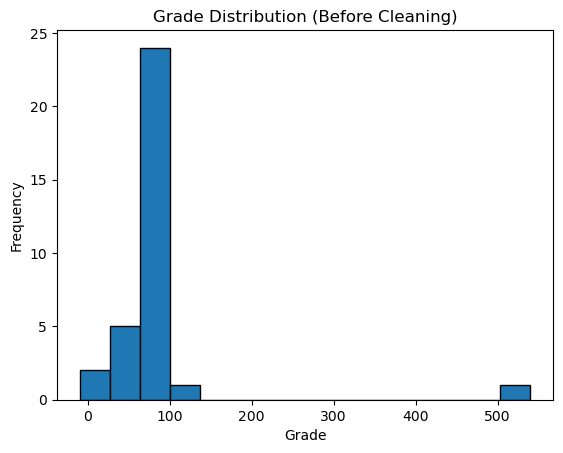

In [6]:

plt.figure()
df_dirty["Grade"].plot(kind="hist", bins=15, edgecolor="black")
plt.title("Grade Distribution (Before Cleaning)")
plt.xlabel("Grade")
plt.ylabel("Frequency")
plt.show()


## 7) Cleaning Strategy (Documented Rules)

We will apply **clear, reproducible** rules:
1. **Fix obvious 10× typos**: if `Grade > 100` *and* ends with `0`, divide by 10 (e.g., `540 → 54`).  
2. **Clip out-of-range values**: after step 1, clip remaining grades to `[0, 100]`.  
3. **Impute missing values**: use the **median** (robust to outliers) of valid grades.  
4. Keep a **cleaning log** of what changed.

> Replace these with your own rules when you switch to your dataset.


In [7]:

df_clean = df_dirty.copy()

cleaning_log = []

# 1) Fix 10x typos
ten_x_mask = df_clean["Grade"].apply(lambda x: isinstance(x, (int, float)) and x>100 and abs(x/10 - round(x/10)) < 1e-9)
df_clean.loc[ten_x_mask, "Grade"] = df_clean.loc[ten_x_mask, "Grade"] / 10.0
cleaning_log.append(f"Divided {ten_x_mask.sum()} suspected 10x-typo grade(s) by 10.")

# 2) Clip to [0, 100]
before_clip_out_of_range = ((df_clean["Grade"] < 0) | (df_clean["Grade"] > 100)).sum(skipna=True)
df_clean["Grade"] = df_clean["Grade"].clip(lower=0, upper=100)
after_clip_out_of_range = ((df_clean["Grade"] < 0) | (df_clean["Grade"] > 100)).sum(skipna=True)
cleaning_log.append(f"Clipped out-of-range values: before={before_clip_out_of_range}, after={after_clip_out_of_range}.")

# 3) Impute missing with median of valid grades
median_grade = df_clean["Grade"].median(skipna=True)
n_missing = df_clean["Grade"].isna().sum()
df_clean["Grade"] = df_clean["Grade"].fillna(median_grade)
cleaning_log.append(f"Imputed {n_missing} missing grade(s) with median={median_grade:.1f}.")

print("\n".join(cleaning_log))
df_clean.head(10)

Divided 1 suspected 10x-typo grade(s) by 10.
Clipped out-of-range values: before=3, after=0.
Imputed 2 missing grade(s) with median=72.0.


,FirstName,LastName,Grade
0,Alex,Smith,77.8
1,Taylor,Lee,78.5
2,Jordan,Patel,54.0
3,Riley,Brown,64.6
4,Casey,Martin,65.3
5,Avery,Garcia,61.7
6,Morgan,Nguyen,68.4
7,Quinn,Johnson,65.0
8,Jamie,Williams,79.8
9,Skyler,Davis,66.7



## 8) Validate After Cleaning

Double‑check:
- No missing grades
- All grades within `[0, 100]`
- Summary stats look reasonable


In [8]:

print("Any missing now?", df_clean["Grade"].isna().any())
print("Any out-of-range now?", ((df_clean["Grade"] < 0) | (df_clean["Grade"] > 100)).any())
display(df_clean.describe())

Any missing now? False
Any out-of-range now? False


,Grade
count,35.000000
mean,69.477143
std,20.936094
min,0.000000
25%,64.800000
50%,72.000000
75%,80.550000
max,100.000000



## 9) Visualize Distribution (After Cleaning)

Compare with the earlier plot. Is the distribution more plausible?


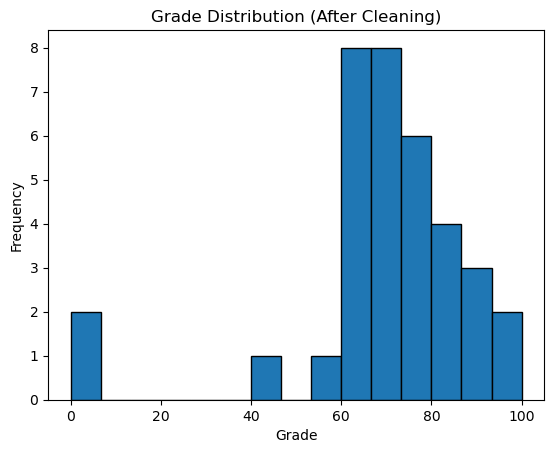

In [9]:

plt.figure()
df_clean["Grade"].plot(kind="hist", bins=15, edgecolor="black")
plt.title("Grade Distribution (After Cleaning)")
plt.xlabel("Grade")
plt.ylabel("Frequency")
plt.show()


## 10) Save Outputs

Save both the **raw-with-issues** and **cleaned** datasets to `outputs/` for your portfolio repo.


In [10]:

from pathlib import Path
out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True, parents=True)

raw_path = out_dir / "student_grades_raw.csv"
clean_path = out_dir / "student_grades_clean.csv"

df_dirty.to_csv(raw_path, index=False)
df_clean.to_csv(clean_path, index=False)

print(f"Saved raw → {raw_path}")
print(f"Saved clean → {clean_path}")

Saved raw → outputs\student_grades_raw.csv
Saved clean → outputs\student_grades_clean.csv



## 11) Reflection 

- Which checks caught the most issues?
- Which assumptions did you make? Are they defensible?
- If this were a production pipeline, how would you log anomalies and fixes?
- What would you change if you had categorical grades (A/B/C) instead of numeric?


**Answers:**

- **Which checks caught the most issues?**  
  The range checks caught the most issues (5 total: 2 negative values, 2 values >100, and 1 extreme value of 540). The missing value check found 2 missing grades. The 10x typo detection identified 1 obvious case (540 → 54). In total, the clipping operation handled 3 out-of-range values after the 10x correction.

- **Which assumptions did you make? Are they defensible?**  
  1. **10x typo assumption**: Values >100 that are divisible by 10 are likely typos. This is defensible for grade data where scores shouldn't exceed 100, though it could be improved by checking if dividing by 10 results in a plausible grade range (e.g., 0-100).
  2. **Clipping to [0, 100]**: All valid grades must be between 0 and 100. This is standard and defensible for percentage-based grading systems.
  3. **Median imputation**: Missing values are imputed using the median (72.0) rather than mean, which is robust to outliers. This is defensible as it preserves the distribution's central tendency without being skewed by extreme values. However, one could argue for domain-specific approaches (e.g., treating missing as incomplete work).

- **If this were a production pipeline, how would you log anomalies and fixes?**  
  I would implement structured logging with the following approach:
  - **Structured log format** (e.g., JSON) with fields: `timestamp`, `row_index`, `column_name`, `original_value`, `issue_type`, `fix_applied`, `new_value`, `confidence_score`
  - **Separate logging levels**: WARN for anomalies detected, INFO for fixes applied, ERROR for unresolved issues
  - **Persistent storage**: Log to both a file (for immediate review) and a database table (for querying trends over time)
  - **Summary statistics**: Aggregate counts by issue type (missing, out-of-range, typos) for monitoring and alerting
  - **Audit trail**: Maintain a separate table/file mapping each row's transformation history for traceability
  - **Thresholds and alerts**: Set up alerts when anomaly rates exceed expected thresholds (e.g., >5% missing values)

- **What would you change if you had categorical grades (A/B/C) instead of numeric?**  
  The approach would need significant changes:
  1. **Invalid category detection**: Check for values not in the valid set (e.g., "A", "B", "C", "D", "F"). Handle case sensitivity, whitespace, and typos (e.g., "A+", "a", " A ").
  2. **Imputation method**: Use mode (most frequent category) instead of median. Could also use forward-fill or domain rules (e.g., default to "F" for missing).
  3. **No clipping or 10x fixes**: These numeric corrections don't apply. Instead, implement fuzzy matching or spell-checking for typo detection (e.g., "B" vs "8" in handwriting scans).
  4. **Validation rules**: Check for invalid transitions (e.g., if grades are ordered, ensure no impossible sequences). Verify categorical consistency across related fields.
  5. **Visualization**: Use bar charts or pie charts instead of histograms. Distribution analysis would focus on category frequencies and proportions.
  6. **Cleaning strategy**: Might need more manual review or ML-based classification for ambiguous cases, rather than purely rule-based fixes.
